In [1]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.4 MB/s 
     |████████████████████████████████| 482 kB 59.6 MB/s 
     |████████████████████████████████| 41 kB 571 kB/s 


In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

In [26]:
dataset = datasets.PROTEINS()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

In [5]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,1113.0,1113.0
mean,39.1,145.6
std,45.8,169.3
min,4.0,10.0
25%,15.0,56.0
50%,26.0,98.0
75%,45.0,174.0
max,620.0,2098.0


In [29]:
graph_labels.value_counts().to_frame()

,0
2,
0,663
1,450


In [28]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [27]:
graph_labels

1       1
2       1
3       1
4       1
5       1
       ..
1109    2
1110    2
1111    2
1112    2
1113    2
Name: label, Length: 1113, dtype: category
Categories (2, object): ['1', '2']

In [8]:
generator = PaddedGraphGenerator(graphs=graphs)

In [9]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Use fn_output_signature instead


In [10]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [11]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

In [12]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

In [13]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [14]:
epochs = 100

In [15]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


21/21 [==============================] - 5s 163ms/step - loss: 0.6497 - acc: 0.6044 - val_loss: 0.6150 - val_acc: 0.6161
Epoch 2/100
21/21 [==============================] - 3s 141ms/step - loss: 0.6226 - acc: 0.6523 - val_loss: 0.6075 - val_acc: 0.7589
Epoch 3/100
21/21 [==============================] - 3s 144ms/step - loss: 0.6030 - acc: 0.6953 - val_loss: 0.6030 - val_acc: 0.7321
Epoch 4/100
21/21 [==============================] - 3s 139ms/step - loss: 0.6007 - acc: 0.7133 - val_loss: 0.5989 - val_acc: 0.7054
Epoch 5/100
21/21 [==============================] - 3s 141ms/step - loss: 0.5882 - acc: 0.7133 - val_loss: 0.5964 - val_acc: 0.6964
Epoch 6/100
21/21 [==============================] - 3s 138ms/step - loss: 0.5839 - acc: 0.7253 - val_loss: 0.5943 - val_acc: 0.7143
Epoch 7/100
21/21 [==============================] - 3s 125ms/step - loss: 0.5805 - acc: 0.7183 - val_loss: 0.5928 - val_acc: 0.7054
Epoch 8/100
21/21 [==============================] - 3s 123ms/step - loss: 0.5824

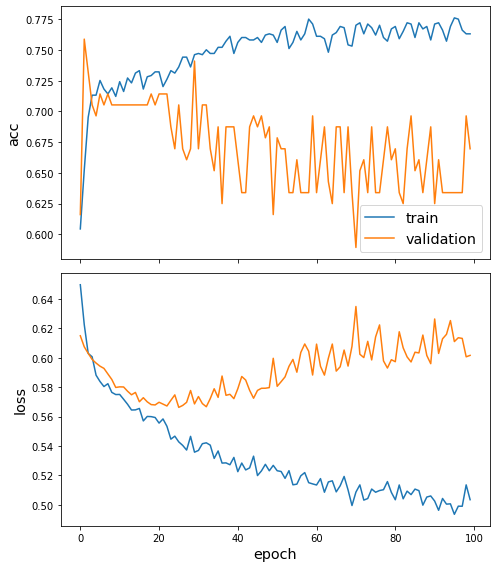

In [16]:
sg.utils.plot_history(history)

In [17]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

112/112 [==============================] - 0s 3ms/step - loss: 0.6017 - acc: 0.6696

Test Set Metrics:
	loss: 0.6017
	acc: 0.6696


In [32]:
prediction= model.predict_generator(test_gen)
prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


array([[0.10320002],
       [0.34881192],
       [0.5109283 ],
       [0.23822856],
       [0.28874344],
       [0.9227419 ],
       [0.1277923 ],
       [0.86906576],
       [0.61681676],
       [0.30933654],
       [0.9202517 ],
       [0.88623   ],
       [0.36961848],
       [0.5049988 ],
       [0.26751202],
       [0.13236886],
       [0.68828386],
       [0.8551714 ],
       [0.08666143],
       [0.31979316],
       [0.28522837],
       [0.46348938],
       [0.16622224],
       [0.4565159 ],
       [0.564253  ],
       [0.3672201 ],
       [0.53613853],
       [0.3661753 ],
       [0.38116157],
       [0.17243877],
       [0.12773469],
       [0.5803811 ],
       [0.24879771],
       [0.13291973],
       [0.47135803],
       [0.43589896],
       [0.15153569],
       [0.3124104 ],
       [0.23630306],
       [0.1591155 ],
       [0.40861067],
       [0.2351658 ],
       [0.9056144 ],
       [0.8389677 ],
       [0.19199151],
       [0.9309602 ],
       [0.511816  ],
       [0.941